# Zurich Land Cover Classification

This script presents a visualization of training a U-Net classifier on 7 out of 8 available land cover classes of the Zurich dataset, and detecting the unseen class using a Density Forest.

## Import Libraries

In [1]:
%matplotlib inline
# python libraries
from multiprocessing import cpu_count
from sklearn.manifold import TSNE
import sys
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from sklearn import decomposition, svm, preprocessing
from sklearn.utils import class_weight
from sklearn.mixture import GaussianMixture
from keras.utils import to_categorical
from keras.models import load_model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# custom libraries
base_dir = '/Users/cyrilwendl/Documents/EPFL'
#base_dir = '/raid/home/cwendl'  # for guanabana
sys.path.append(base_dir + '/SIE-Master/Code')  # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master')  # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code/density_tree')  # Path to density Tree package
from helpers.helpers import *
from helpers.data_augment import *
from helpers.data_loader import ZurichLoader
from helpers.cv_scorers import *
from helpers.cross_validator import ParameterSearch
from baselines.helpers import predict_with_dropout_imgs
from density_forest.density_forest import *
from density_forest.plots import *
from density_forest.helpers import *
from keras_helpers.unet import *
from keras_helpers.callbacks import *

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12661280909064654278
]


In [2]:
class_to_remove = 6

# Load Data

In [3]:
path = os.getcwd()
data_train = ZurichLoader(path, 'train')
data_val = ZurichLoader(path, 'val')
data_test = ZurichLoader(path, 'test')

In [4]:
# data with overlap, for prediction
data_train_overlap = ZurichLoader(path, 'train', stride=32)
data_val_overlap = ZurichLoader(path, 'val', stride=32)
data_test_overlap = ZurichLoader(path, 'test', stride=32)

In [5]:
names = data_train.names
colors = data_train.colors

In [6]:
# remove class
n_classes = 9
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])

names_keep = np.asarray(names)[classes_to_keep]
names_keep = names_keep.tolist()
print("classes to keep: " + str(names_keep))

classes to keep: ['Roads', 'Buildings', 'Trees', 'Grass', 'Bare Soil', 'Railways', 'Swimming Pools']


# CNN Training

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

In [7]:
"""
# create copies of original data
y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))
"""

'\n# create copies of original data\ny_train_label = y_train.copy()\ny_val_label = y_val.copy()\ny_test_label = y_test.copy()\n\n# get class weights\nlabels_unique = np.unique(y_train.flatten())\nprint(labels_unique)\nclass_weights = class_weight.compute_class_weight(\'balanced\', labels_unique, y_train.flatten())\nclass_weights[0] = 0  # give less weight to background label class\nclass_weights[5] = 7  # give less weight to bare soil class\nclass_weights[8] = 7  # give less weight to swimming pool class\n\nprint("Class weights:")\nfor i, w in enumerate(class_weights):\n    print("%15s: %3.3f" % (names[i], w))\n'

In [8]:
"""

# convert to numpy arrays
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))
"""

'\n\n# convert to numpy arrays\nx_train = np.asarray(x_train)\nx_val = np.asarray(x_val)\nx_test = np.asarray(x_test)\n\n# make y data categorical\ny_train = to_categorical(y_train_label, n_classes)\ny_val = to_categorical(y_val_label, n_classes)\n\ny_train = y_train[..., classes_to_keep]\ny_val = y_val[..., classes_to_keep]\nn_classes = len(classes_to_keep)\nclass_weights = class_weights[classes_to_keep]\n\n# print shapes of variables\nfor var in x_train, y_train, x_val, y_val:\n    print(np.shape(var))\n'

### Train CNN

In [9]:
"""
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./tensorboard', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   # callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count(),
                        use_multiprocessing=True)
                        
"""

'\n# callbacks (evaluated every epoch)\n# show loss and accuracy figures after each epoch\ncallback_plot = PlotLosses()\n\n# stop early if after several epochs the accuracy doesn\'t improve\ncallback_earlystop = EarlyStopping(monitor=\'val_loss\', min_delta=1e-4, patience=24, verbose=1, mode=\'auto\')\n\n# decrease learning rate when accuracy stops improving\ncallback_lr = ReduceLROnPlateau(monitor=\'val_loss\', factor=0.5, patience=12, verbose=1, mode=\'auto\',\n                                epsilon=1e-4, cooldown=0, min_lr=1e-8)\n\n# checkpoint to save weights at every epoch (in case of interruption)\nfile_path = "weights-improvement.hdf5"\ncallback_checkpoint = ModelCheckpoint(file_path, monitor=\'val_acc\', verbose=0, save_best_only=True, mode=\'max\')\n\ncallback_tensorboard = TensorBoard(log_dir=\'./tensorboard\', histogram_freq=0, write_graph=True, write_images=True)\n\n# model setup\nbatch_size = 20\nepochs = 300\n\n\ndef model_train(model, data_augmentation):\n    # Fit the 

In [10]:
# train or load model
# train the model
# model_unet = get_unet(n_classes, x_train.shape[1:])
# model_train(model_unet, data_augmentation=True)
# model_unet.save('models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '_2.h5')  # save model, weights

In [11]:
# load model
name_model = path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '.h5'    
model_unet = load_model(name_model, custom_objects={'fn': ignore_background_class_accuracy(0)})

### Prediction on Test Set

In [17]:
# get prediction
y_pred_te = model_unet.predict(data_test_overlap.im_patches, batch_size=20, verbose=1)

# prediction patches without overlapping patches
y_pred_te = np.concatenate(remove_overlap(data_test.imgs, y_pred_te, np.arange(4), 64, 32))

# get label
y_pred_label_te = get_y_pred_labels(y_pred_te, class_to_remove=class_to_remove)

# get accuracy as softmax pseudo-probability
y_pred_acc = np.max(y_pred, axis=-1)

# Get accuracy as margin between highest and second highest class
y_pred_acc_margin = get_acc_net_max_margin(y_pred)

3902/3902 [==============================] - 150s 38ms/step


In [18]:
# prediction image
y_pred_acc_imgs = [convert_patches_to_image(data_test.imgs, y_pred_acc[..., np.newaxis], 
                                            img_idx=idx_im, img_start=0, patch_size=64, stride=64) 
                   for idx_im in np.arange(4)]

In [19]:
y_pred_im = [convert_patches_to_image(data_test.imgs, gt_label_to_color(y_pred_label, colors), 
                                      img_idx=i, img_start=0, patch_size=64, stride=64) 
             for i in np.arange(4)]

### Accuracy Metrics (Test Set)

In [20]:
# Accuracy metrics
y_pred_flattened = np.asarray(y_pred_label.flatten()).astype('int')
y_test_flattened = np.asarray(data_test.gt_patches.flatten()).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

# Class accuracy, average accuracy
print(metrics.classification_report(
    y_test_flattened[filter_items],
    y_pred_flattened[filter_items],
    target_names=names_keep,
    digits=3))


# Overall accuracy
OA = metrics.accuracy_score(y_test_flattened[filter_items], y_pred_flattened[filter_items])
print("Overall accuracy: %.3f %%" % (OA*100))

                precision    recall  f1-score   support

         Roads      0.772     0.926     0.842    520742
     Buildings      0.870     0.886     0.878    470587
         Trees      0.835     0.824     0.829    545015
         Grass      0.937     0.777     0.849    612397
     Bare Soil      0.667     0.727     0.696     66093
      Railways      0.001     0.001     0.001     18526
Swimming Pools      0.000     0.000     0.000     10386

   avg / total      0.840     0.834     0.833   2243746

Overall accuracy: 83.448 %


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Network

In [21]:
# get all predictions in training and test set
# training set
y_pred_tr = model_unet.predict(data_train_overlap.im_patches, verbose=1)
y_pred_tr = np.concatenate(remove_overlap(data_train.imgs, y_pred_tr, np.arange(12), 64, 32))
y_pred_label_tr = get_y_pred_labels(y_pred_tr, class_to_remove=class_to_remove, background=True)

# validation set
y_pred_val = model_unet.predict(data_val_overlap.im_patches, verbose=1)
y_pred_val = np.concatenate(remove_overlap(data_val.imgs, y_pred_val, np.arange(4), 64, 32))
y_pred_label_val = get_y_pred_labels(y_pred_val, class_to_remove=class_to_remove, background=True)

# test set already done above

4468/4468 [==============================] - 164s 37ms/step


In [22]:
# get indices of correctly / incorrectly predicted pixels
# with error in known classes
# only known classes (novely detection)
pred_t_tr = (data_train.gt_patches != class_to_remove) & (data_train.gt_patches != 0)
pred_f_tr = data_train.gt_patches == class_to_remove

pred_t_val = (data_val.gt_patches != class_to_remove) & (data_val.gt_patches != 0)
pred_f_val = data_val.gt_patches == class_to_remove

pred_t_te = (data_test.gt_patches != class_to_remove) & (data_test.gt_patches != 0)
pred_f_te = data_test.gt_patches == class_to_remove

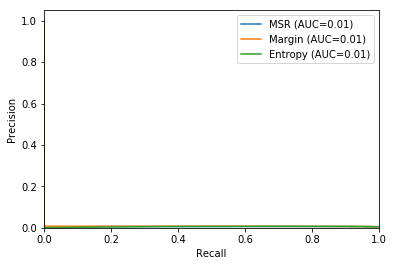

In [23]:
# precision-recall curves

# msr
y_scores = (-get_acc_net_msr(y_pred_te)).flatten()
y_true = pred_f_te.flatten()
precision_msr, recall_msr, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_msr = metrics.average_precision_score(y_true, y_scores)
auroc_msr = metrics.roc_auc_score(y_true, y_scores)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, y_scores)

# margin
y_scores = (-get_acc_net_max_margin(y_pred_te)).flatten()
precision_margin, recall_margin, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_margin = metrics.average_precision_score(y_true, y_scores)
auroc_margin = metrics.roc_auc_score(y_true, y_scores)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, y_scores)

# entropy
y_scores = (-get_acc_net_entropy(y_pred_te)).flatten()
precision_entropy, recall_entropy, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_entropy = metrics.average_precision_score(y_true, y_scores)
auroc_entropy = metrics.roc_auc_score(y_true, y_scores)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, y_scores)


# plot
plt.step(recall_msr, precision_msr, where='post')
plt.step(recall_margin, precision_margin, where='post')
plt.step(recall_entropy, precision_entropy, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('MSR (AUC=%.2f)' % pr_auc_msr),
            str.format('Margin (AUC=%.2f)' % pr_auc_margin),
            str.format('Entropy (AUC=%.2f)' % pr_auc_entropy)])

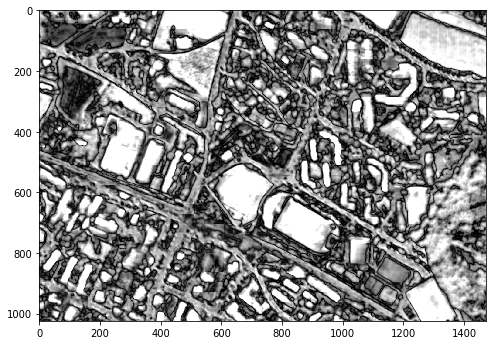

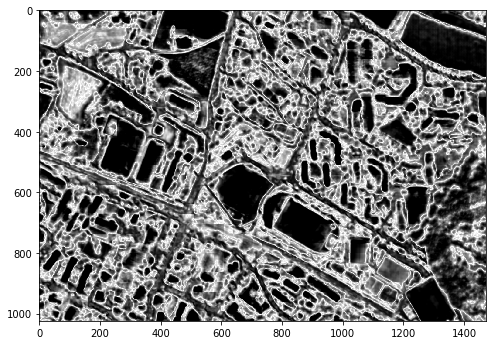

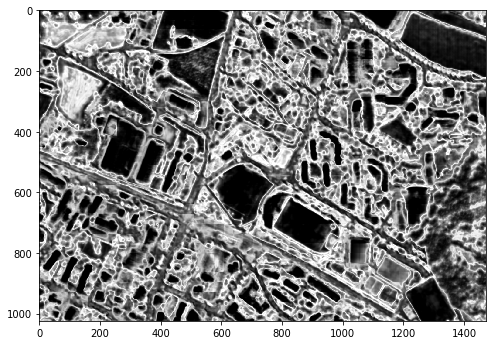

In [24]:
# visualization
# MSR
probas_patches_msr = np.reshape((get_acc_net_msr(y_pred_te)).flatten(), np.shape(data_test.gt_patches))
probas_patches_msr -= np.min(probas_patches_msr)
probas_patches_msr /= np.max(probas_patches_msr)

# show image of DF uncertainty vs. max margin uncertainty
img_idx = 3
acc_im_msr = convert_patches_to_image(data_test.imgs, probas_patches_msr[..., np.newaxis], img_idx, 64, 64, 0)
acc_im_msr = imgs_stretch_eq([acc_im_msr])[0]
plt.figure(figsize=(8, 8))
plt.imshow(acc_im_msr[..., 0], cmap='gray')
plt.show()

# margin
probas_patches_margin = np.reshape((1 - get_acc_net_max_margin(y_pred_te)).flatten(), np.shape(data_test.gt_patches))
probas_patches_margin -= np.min(probas_patches_margin)
probas_patches_margin /= np.max(probas_patches_margin)

# show image of DF uncertainty vs. max margin uncertainty
img_idx = 3
acc_im_margin = convert_patches_to_image(data_test.imgs, probas_patches_margin[..., np.newaxis], img_idx, 64, 64, 0)
acc_im_margin = imgs_stretch_eq([acc_im_margin])[0]
plt.figure(figsize=(8, 8))
plt.imshow(acc_im_margin[..., 0], cmap='gray')
plt.show()

# entropy
probas_patches_entropy = np.reshape((1 - get_acc_net_entropy(y_pred_te)).flatten(), np.shape(data_test.gt_patches))
probas_patches_entropy -= np.min(probas_patches_entropy)
probas_patches_entropy /= np.max(probas_patches_entropy)

# show image of DF uncertainty vs. max entropy uncertainty
img_idx = 3
acc_im_entropy = convert_patches_to_image(data_test.imgs, probas_patches_entropy[..., np.newaxis], img_idx, 64, 64, 0)
acc_im_entropy = imgs_stretch_eq([acc_im_entropy])[0]
plt.figure(figsize=(8, 8))
plt.imshow(acc_im_entropy[..., 0], cmap='gray')
plt.show()

## Dropout

In [ ]:
# get predictions
y_preds = predict_with_dropout_imgs(model_unet, data_test_overlap.im_patches,
                                    data_test.imgs, np.arange(4), batch_size=500,
                                    n_iter=20)

In [ ]:
# get prediction and confidence
prediction = np.mean(y_preds, 0)
probas_dropout = -get_acc_net_entropy(prediction)

In [ ]:
# dropout metrics
y_scores = probas_dropout.flatten()
precision_dropout, recall_dropout, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_dropout = metrics.average_precision_score(y_true, y_scores)
auroc_dropout = metrics.roc_auc_score(y_true, y_scores)
fpr_dropout, tpr_dropout, _ = metrics.roc_curve(y_true, y_scores)
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_dropout, pr_auc_dropout))

In [ ]:
# show image of DF uncertainty vs. max margin uncertainty
probas_patches_margin = np.reshape(y_scores, np.shape(data_test.gt_patches))
probas_patches_margin -= np.min(probas_patches_margin)
probas_patches_margin /= np.max(probas_patches_margin)

img_idx = 3
acc_im_margin = convert_patches_to_image(data_test.imgs, probas_patches_margin[..., np.newaxis], img_idx, 64, 64, 0)
acc_im_margin = imgs_stretch_eq([acc_im_margin])[0]
plt.figure(figsize=(8, 8))
plt.imshow(acc_im_margin[..., 0], cmap='gray')
plt.show()

## Retrieve Activations, PCA, t-SNE

In [ ]:
# get activations for training Density Forest
act_train_all = get_activations_batch(model_unet, -2, data_train_overlap.im_patches, 20, verbose=True)

# retain only activation weights for which there is a ground truth
act_train_all = np.concatenate(remove_overlap(data_train.imgs, act_train_all, np.arange(12), patch_size=64, stride=32))
act_train = act_train_all[pred_t_tr]

In [ ]:
# get activations
act_val_all = get_activations_batch(model_unet, -2, data_val_overlap.im_patches, 20, verbose=True)

# retain only activation weights for which there is a ground truth
act_val_all = np.concatenate(remove_overlap(data_val.imgs, act_val_all, np.arange(4), patch_size=64, stride=32))
act_val = act_val_all[pred_t_val]

In [ ]:
# get activations for testing Density Forest
act_test = get_activations_batch(model_unet, -2, data_test_overlap.im_patches, 20, verbose=True)

# remove test activations overlap
act_test = remove_overlap(data_test.imgs, act_test, np.arange(4), patch_size=64, stride=32)
act_test = np.concatenate(np.concatenate(np.concatenate(act_test)))

In [ ]:
# get balanced data subset to show in figure
tsne_pts_per_class = 200
dataset_subset_indices = get_balanced_subset_indices(data_test.gt_patches.flatten(), 
                                                     np.arange(1, 9), pts_per_class=tsne_pts_per_class)
dataset_subset_indices = np.concatenate(dataset_subset_indices)

In [ ]:
# t-SNE visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_all = tsne.fit_transform(act_test[dataset_subset_indices])
tsne_y = data_test.gt_patches.flatten()[dataset_subset_indices]

In [ ]:
# plot
_, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, names, colors, class_to_remove=class_to_remove)

In [ ]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=.95)
pca.fit(act_test)  # fit on training set without background pixels
n_components = np.alen(pca.explained_variance_ratio_)
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_)))

# transform training activations
act_train_all = pca.transform(np.concatenate(np.concatenate(act_train_all)))
act_train = pca.transform(act_train)

act_val_all = pca.transform(np.concatenate(np.concatenate(act_val_all)))
act_val = pca.transform(act_val)


# transform test set activations
act_test = pca.transform(act_test)

In [ ]:
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(act_test[dataset_subset_indices])
# tsne without unseen class
tsne_train = tsne_all[tsne_y != class_to_remove]
# plot
_, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, names, colors, class_to_remove=class_to_remove)

In [ ]:
# plot first 3 PCA components
plot_pts_3d(act_test[:, :3], data_test.gt_patches.flatten(), classes_to_keep, names, colors,
            class_to_remove=class_to_remove, subsample_pct=.0003)

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

In [ ]:
# plot first 2 PCA components
_, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_pts_2d(act_test[:, :2], data_test.gt_patches.flatten(), ax, classes_to_keep, names, colors,
            class_to_remove=class_to_remove, subsample_pct=.0005)

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

## GMM

In [ ]:
tuned_parameters = [{'n_components': np.arange(3, 12), 
                     'max_iter': [10000]}]

# do parameter search
ps_gmm = ParameterSearch(GaussianMixture, tuned_parameters, act_train, act_val_all,
                         pred_f_val.flatten(), scorer_roc_probas_gmm, 
                         n_iter=3, verbosity=10, n_jobs=-1, subsample_train=.01, subsample_test=.01)
ps_gmm.fit()

In [ ]:
ps_gmm.best_params

In [ ]:
# Fit GMM
gmm = GaussianMixture(**ps_gmm.best_params)
gmm.fit(draw_subsamples(act_train, .01))

# Predict
probas_gmm = gmm.predict_proba(act_test)
probas_gmm = get_acc_net_entropy(probas_gmm)

In [ ]:
# plot
# dataset_subset_indicesices of correctly / wrongly predicted points
pred_f = pred_f_te.flatten()[dataset_subset_indices]
pred_t = pred_t_te.flatten()[dataset_subset_indices]

# plot colors
probas_gmm_c = imgs_stretch_eq([probas_gmm[..., np.newaxis]])[0, ..., 0]
colors_plt = plt.cm.YlOrRd(1 - probas_gmm_c)[:, :3][dataset_subset_indices]

# threshold for second plot
c_thresh_t = plt.cm.YlOrRd((probas_gmm_c[dataset_subset_indices] <
                            np.sort(probas_gmm_c[dataset_subset_indices])[200])*255)[:, :3]
c_thresh_f = plt.cm.YlOrRd((probas_gmm_c[dataset_subset_indices] > 
                            np.sort(probas_gmm_c[dataset_subset_indices])[200])*255)[:, :3]

# plot correctly predicted points (o marker)
_, axes = plt.subplots(1, 2, figsize=(20, 10)) 
axes[0].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=colors_plt[pred_t], alpha=.6)
axes[1].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=c_thresh_t[pred_t])

# plot incorrectly predicted points (x marker)
axes[0].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=colors_plt[pred_f], marker='x')
axes[1].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=c_thresh_f[pred_f], marker='x')
plt.show()

In [ ]:
# precision-recall curve
y_scores = -probas_gmm
precision_gmm, recall_gmm, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_gmm = metrics.auc(recall_gmm, precision_gmm)
fpr_gmm, tpr_gmm, _ = metrics.roc_curve(y_true, y_scores)
auroc_gmm = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_gmm, precision_gmm)
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_gmm, pr_auc_gmm))

In [ ]:
# visualization
probas_patches_gmm = np.reshape(probas_gmm, np.shape(data_test.gt_patches))
probas_patches_gmm -= np.min(probas_patches_gmm)
probas_patches_gmm /= np.max(probas_patches_gmm)
probas_patches_gmm = 1 - probas_patches_gmm

# show image of DF uncertainty vs. max margin uncertainty
img_idx = 3
acc_im_gmm = convert_patches_to_image(data_test.imgs, probas_patches_gmm[..., np.newaxis], img_idx, 64, 64, 0)
acc_im_gmm = imgs_stretch_eq([acc_im_gmm])[0]
plt.figure(figsize=(8, 8))
plt.imshow(acc_im_gmm[..., 0], cmap='gray')
plt.show()


# SVM

In [ ]:
act_train_svm = preprocessing.scale(act_train)
act_val_all_svm = preprocessing.scale(act_val_all)
act_test_svm = preprocessing.scale(act_test)

In [ ]:
tuned_parameters = [{'kernel': ['rbf'],
                     'nu': [.001, .5, .99]
                     },
                    {'kernel': ['poly'],
                     'degree': np.arange(1, 17),
                     'nu': [1e-4, 1e-3, 1e-2, .1, .3, .5],
                     'max_iter': [10000]}]

# do parameter search
ps_svm = ParameterSearch(svm.OneClassSVM, tuned_parameters, act_train_svm, act_val_all_svm, 
                         pred_f_val.flatten(), scorer_roc_probas_svm, n_iter=5,
                         verbosity=11, n_jobs=-1, subsample_train=.001, subsample_test=.01)
ps_svm.fit()

In [ ]:
print(ps_svm.best_params)

In [ ]:
# Fit SVM
clf_svm = svm.OneClassSVM(**ps_svm.best_params)
clf_svm.fit(draw_subsamples(act_train_svm, .001))

In [ ]:
# predict
probas_svm = clf_svm.decision_function(act_test_svm[dataset_subset_indices])
probas_svm -= np.min(probas_svm)
probas_svm /= np.max(probas_svm)

In [ ]:
# plot
pred_f = pred_f_te.flatten()[dataset_subset_indices]
pred_t = pred_t_te.flatten()[dataset_subset_indices]

# plot colors
probas_svm_c = probas_svm[..., 0]
colors_plt = plt.cm.YlOrRd(1 - probas_svm_c)[..., :3]

# threshold for second plot
c_thresh_t = plt.cm.YlOrRd((probas_svm_c < np.sort(probas_svm_c)[200])*255)[:, :3]

c_thresh_f = plt.cm.GnBu((probas_svm_c > np.sort(probas_svm_c)[200])*255)[:, :3]

# plot correctly predicted points (o marker)
_, axes = plt.subplots(1, 2, figsize=(20, 10)) 
axes[0].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=colors_plt[pred_t])
axes[1].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=c_thresh_t[pred_t])

# plot incorrectly predicted points (x marker)
axes[0].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=colors_plt[pred_f], marker='x')
axes[1].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=c_thresh_f[pred_f], marker='x')
plt.show()

In [ ]:
probas_svm = clf_svm.decision_function(act_test_svm)
probas_svm -= np.min(probas_svm)
probas_svm /= np.max(probas_svm)

In [ ]:
# precision-recall curve
y_scores = -probas_svm
# PR
precision_svm, recall_svm, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_svm = metrics.auc(recall_svm, precision_svm)

# ROC
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, y_scores)
auroc_svm = metrics.roc_auc_score(y_true, y_scores)

In [ ]:
auroc_svm, pr_auc_svm

## Density Forest

In [ ]:
# Create DensityForest instance
clf_df = DensityForest(max_depth=2, min_subset=.1, n_trees=100,
                       subsample_pct=.1, n_jobs=-1, verbose=10,
                       ig_improvement=.4)

In [ ]:
# fit to training data
clf_df.fit(tsne_train)

In [ ]:
# Show ellipses on plot
_, axes = plt.subplots(2, 2, figsize=(15, 15)) 
for i in range(4):
    plot_pts_2d(tsne_all, tsne_y, axes[int(i/2)][np.mod(i, 2)], classes_to_keep, names, 
                colors, class_to_remove=class_to_remove)
    covs, means = get_clusters(clf_df.root_nodes[i], [], [])
    plot_ellipses(axes[int(i / 2)][np.mod(i, 2)], means, covs)

In [ ]:
# export some ellipses for GIF

for i in range(10):
    _, ax = plt.subplots(1, 1, figsize=(8, 8)) 
    plt.xlim([-50, 50])
    plt.ylim([-50, 50])
    plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, names, colors, 
                class_to_remove=class_to_remove)
    covs, means = get_clusters(clf_df.root_nodes[i], [], [])
    plot_ellipses(ax, means, covs)
    plt.axis('off')
    plt.savefig("../Figures/Zurich/GIF/TSNE_act_wo_cl" + str(class_to_remove) + "_"+str(i)+".pdf", 
                bbox_inches='tight', pad_inches=0)

In [ ]:
# plot

# get probabilities for all images
probas_df = np.log(clf_df.predict(tsne_all))

# indices of correctly / wrongly predicted points
pred_f = pred_f_te.flatten()[dataset_subset_indices]
pred_t = pred_t_te.flatten()[dataset_subset_indices]

# plot colors
probas_df_c = imgs_stretch_eq(probas_df[np.newaxis, ..., np.newaxis])[0, ..., 0]
colors_plt = plt.cm.YlOrRd(1 - probas_df_c)[..., :3]

# threshold for second plot
c_thresh_t = plt.cm.GnBu((probas_df < np.sort(probas_df)[tsne_pts_per_class])*255)[:, :3]

c_thresh_f = plt.cm.GnBu((probas_df > np.sort(probas_df)[tsne_pts_per_class])*255)[:, :3]

# plot correctly predicted points (o marker)
fig, axes = plt.subplots(1, 2, figsize=(20, 10)) 
axes[0].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=colors_plt[pred_t])
axes[1].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=c_thresh_t[pred_t])

# plot incorrectly predicted points (x marker)
axes[0].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=colors_plt[pred_f], marker='x')
axes[1].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=c_thresh_f[pred_f], marker='x')
[axes[i].legend(['Seen points', 'Novel points']) for i in range(2)]
[axes[i].set_axis_off() for i in range(2)]
extent = axes[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig("../Figures/Zurich/GIF/probas.pdf", bbox_inches=extent, pad_inches=0)
plt.show()

### Fit on real data

In [ ]:
default_params = {'n_trees': 10, 
                   'n_max_dim': 0,
                   'n_jobs': -1,
                   'verbose': 0,
                   'subsample_pct': .0002
                  }

tuned_params = [{'max_depth': [2, 3, 4],
                 'min_subset': [.01, .005, .001],
                 'ig_improvement': [0, .3, .5]}]
                 

# do parameter search
ps_df = ParameterSearch(DensityForest, tuned_params, act_train[..., :3], act_val_all[..., :3], 
                        pred_f_val.flatten(), scorer_roc_probas_df,
                        n_iter=3, verbosity=11, n_jobs=1, subsample_train=1, 
                        subsample_test=.01, default_params=default_params)

print("Testing %i combinations %i times" % (len(ps_df.combinations), ps_df.n_iter))
print(ps_df.combinations)
ps_df.fit()

In [ ]:
ps_df.best_params

In [ ]:
default_params['verbose'] = 1
default_params['batch_size'] = 10000

In [ ]:
# Create DensityForest instance
clf_df = DensityForest(**ps_df.best_params, **default_params)

In [ ]:
clf_df.fit(act_train[..., :3])

In [ ]:
# get probabilities for all images
probas_df = clf_df.predict(act_test[..., :3])

In [ ]:
# plot
# indices of correctly / wrongly predicted points
pred_f = pred_f_te.flatten()[dataset_subset_indices]
pred_t = pred_t_te.flatten()[dataset_subset_indices]

# plot colors
#probas_df_c = imgs_stretch_eq(probas_df[dataset_subset_indices, np.newaxis])[0, ..., 0]
probas_df_c = probas_df[dataset_subset_indices]
colors_plt = plt.cm.YlOrRd(1-np.log(probas_df_c))[..., :3]

# threshold for second plot
c_thresh_t = plt.cm.YlOrRd((probas_df_c < np.sort(probas_df_c)[200])*255)[:, :3]
c_thresh_f = plt.cm.YlOrRd((probas_df_c > np.sort(probas_df_c)[200])*255)[:, :3]

# plot correctly predicted points (o marker)
_, axes = plt.subplots(1, 2, figsize=(20, 10)) 
axes[0].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=colors_plt[pred_t])
axes[1].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=c_thresh_t[pred_t])

# plot incorrectly predicted points (x marker)
axes[0].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=colors_plt[pred_f], marker='x')
axes[1].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=c_thresh_f[pred_f], marker='x')
# axes[0].savefig("../Figures/Zurich/GIF/probas.pdf", bbox_inches='tight', pad_inches=0)

### Post-Treatment

In [ ]:
# reshape probas to (n_patches, patch_size, patch_size)
probas_patches_df = np.reshape(probas_df, np.shape(data_test.gt_patches))

# transformations
probas_patches_df -= np.nanmin(probas_patches_df)
probas_patches_df /= np.nanmax(probas_patches_df)

### Metrics

In [ ]:
# metrics
y_scores = -probas_df

# PR
precision_df, recall_df, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_df = metrics.auc(recall_df, precision_df)

# ROC
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, y_scores)
auroc_df = metrics.roc_auc_score(y_true, y_scores)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_df, pr_auc_df))

In [ ]:
# show image of DF uncertainty vs. max margin uncertainty
img_idx = 3
acc_im_df = convert_patches_to_image(data_test.imgs, probas_patches_df[...,np.newaxis], img_idx, 64, 64, 0)
acc_im_df = imgs_stretch_eq([acc_im_df])[0]
plt.figure(figsize=(8, 8))
plt.imshow(acc_im_df[..., 0], cmap='gray')
plt.show()

## Plot Results

In [ ]:
# Precision-Recall Curve
# order according to increasing score
scores_pr = [pr_auc_msr, pr_auc_margin, pr_auc_entropy, pr_auc_dropout, pr_auc_gmm, pr_auc_svm, pr_auc_df]
recalls = [recall_msr, recall_margin, recall_entropy, recall_dropout, recall_gmm, recall_svm, recall_df]
precisions = [precision_msr, precision_margin, precision_entropy, precision_dropout, 
              precision_gmm, precision_svm, precision_df]

names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'OC SVM', 'DF'])
scores_order = np.argsort(scores_pr)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_pr)))[:, :3]

# plot
plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(recalls[i], precisions[i], where='post', c=colors_lines[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_pr[i]) for i in scores_order], title="PR AUC")
plt.savefig("../Figures/Zurich/PR_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
# ROC
# order according to increasing score
scores_auc = [auroc_msr, auroc_margin, auroc_entropy, auroc_dropout, auroc_gmm, auroc_svm, auroc_df]
fprs = [fpr_msr, fpr_margin, fpr_entropy, fpr_dropout, fpr_gmm, fpr_svm, fpr_df]
tprs = [tpr_msr, tpr_margin, tpr_entropy, tpr_dropout, tpr_gmm, tpr_svm, tpr_df]
scores_order = np.argsort(scores_auc)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_auc)))[:, :3]

# plot
plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(fprs[i], tprs[i], where='post', c=colors_lines[i])

plt.plot([0, 1], [0, 1], '--', c='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_auc[i]) for i in scores_order], title="AUROC")
plt.savefig("../Figures/Zurich/ROC_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()